# **Binary Classification - Social Media Tweets**

## **1 - Project Objective and description**
The objective of this project is to develop a classification model using machine learning classification techniques. The goal is to classify Tweets as either positive or negative based on their content. I will compare 3 ML models to choose the best one: Logistic Regression, Random Forest and LightGBM.

## **1.1 - Business Problem**
For this task, our business problem will be to understand trends and public opinions on various topics based on social media posts. For that, we will use an annotated Tweets dataset (positive and negative) and will train a ML model. The model will need to identify overall public sentiment and trends in topics like politics, social issues, or consumer preferences and our key requirements will be:

 -Good performance on both classes.

 -Efficiency in handling large datasets.

 -Quick inference times.


## **1.2 - Dataset Description**
The dataset used for this project is Sentiment140, a widely used dataset containing 1.6 million labeled Tweets. Each Tweets is annotated as:
- 0: Negative sentiment
- 4: Positive sentiment (which I will convert to 1 for binary classification)

To make the dataset more manageable, I will extract a balanced subset of 50,000 tweets (25K positive and 25K negative).

## **1.3 - Project Workflow**
The project consists of the following steps:
1. Data Preprocessing: Loading and preparing the dataset.
2. Exploratory Data Analysis (EDA): Understanding data distribution and key insights.
3. Feature Engineering: Converting text into numerical representations.
4. Model Training: Train the three selected models.
5. Hyperparameter Tuning: Optimizing model performance.
6. Evaluation & Interpretation: Assessing model accuracy and performance.
7. Model saving.

## **Imports**

In the following cells I will import the necessary modules and libraries to execute the notebook.

In [57]:
# Import all the necessary libraries, packages and modules
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")
# Add the utils_1 directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))
# Import the functions from utils.py
import utils
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [58]:
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

## **Step 1: Data Preprocessing - Loading and Preparing the Dataset**

Data preprocessing is a crucial step in any machine learning pipeline. The goal is to clean and prepare the dataset so that it can be efficiently used for analysis and model training. In this step, I will:

1-Load the dataset.

2-Reduce the dataset size to 50K tweets.

3-Remove unnecessary columns and transform some of them.

4-Handle missing or duplicate values.

5-Normalize labels (0 for negative, 1 for positive).

6-Save the cleaned dataset.

In [ ]:
# Load dataset from local file
file_path = "../complete_data/training.1600000.processed.noemoticon.csv"
# Select the important columns and drop the query and user column as I will not be using them
df = pd.read_csv(file_path, encoding="latin-1", header=None, 
                usecols=[0, 1, 2, 5], names=["sentiment", "tweet_id", "date", "text"])
# Mapping sentiment labels (0 = negative, 4 = positive) to (0 = negative,1 = positive)
df['sentiment'] = df['sentiment'].replace({4: 1})
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')
# Extract useful features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek # Monday=0, Sunday=6
df['hour'] = df['date'].dt.hour
# Sampling 25K positive and 25K negative to maintain balance
negative = df[df['sentiment'] == 0]
positive = df[df['sentiment'] == 1]
negative_sample = resample(negative, n_samples=25000, random_state=42)
positive_sample = resample(positive, n_samples=25000, random_state=42)
# Combine and shuffle the dataset
sampled_df = pd.concat([negative_sample, positive_sample]).sample(frac=1, random_state=42).reset_index(drop=True)
# Check for missing values
missing_values = sampled_df.isnull().sum()
print("Missing values per column:\n", missing_values)
# Drop any rows with missing values (if any)
sampled_df.dropna(inplace=True)
# Check for duplicate tweets
duplicate_count = sampled_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")
# Remove duplicates if necessary
sampled_df.drop_duplicates(inplace=True)
# Verify sentiment distribution
print("Sentiment distribution:")
print(sampled_df['sentiment'].value_counts())
# Ensure sentiment labels are binary (0 = Negative, 1 = Positive)
sampled_df['sentiment'] = sampled_df['sentiment'].astype(int)
# Save the cleaned dataset
os.makedirs("../complete_data", exist_ok=True)
sampled_df.to_csv("../complete_data/sentiment140_cleaned_4.csv", index=False)
print("Cleaned dataset saved successfully!")

Missing values per column:
 sentiment      0
tweet_id       0
date           0
text           0
year           0
month          0
day_of_week    0
hour           0
dtype: int64
Number of duplicate rows: 696
Sentiment distribution:
sentiment
1    24652
0    24652
Name: count, dtype: int64
Cleaned dataset saved successfully!


In [ ]:
# Dataset inspection:
sampled_df.head(5)

,sentiment,tweet_id,date,text,year,month,day_of_week,hour
0,0,1467810369,2009-04-06 22:19:45,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009,4,0,22
1,0,1467810672,2009-04-06 22:19:49,is upset that he can't update his Facebook by ...,2009,4,0,22
2,0,1467810917,2009-04-06 22:19:53,@Kenichan I dived many times for the ball. Man...,2009,4,0,22
3,0,1467811184,2009-04-06 22:19:57,my whole body feels itchy and like its on fire,2009,4,0,22
4,0,1467811193,2009-04-06 22:19:57,"@nationwideclass no, it's not behaving at all....",2009,4,0,22


In [9]:
# Dataset inspection:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49304 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   sentiment    49304 non-null  int64         
 1   tweet_id     49304 non-null  int64         
 2   date         49304 non-null  datetime64[ns]
 3   text         49304 non-null  object        
 4   year         49304 non-null  int32         
 5   month        49304 non-null  int32         
 6   day_of_week  49304 non-null  int32         
 7   hour         49304 non-null  int32         
dtypes: datetime64[ns](1), int32(4), int64(2), object(1)
memory usage: 2.6+ MB


## **Step 2: Exploratory Data Analysis (EDA)**
In this step I will analyse and visualize the dataset to understand its structure, feature relationships, etc.
I will also clean it further if necessary, and prepare it for model training.

I will perform the following tasks:

1-Check for basic statistics: Get an overview of the dataset.

2-Visualize the distribution of sentiments: Check the balance of positive and negative tweets.

3-Analyze the text data: Look at the length of tweets, common words, etc.

4-Analyze time-related features: Check for trends over time based on the year, month, day_of_week, and hour features.

In [10]:
# Set plot style
sns.set(style="whitegrid")
# Display basic statistics
print("Basic Statistics of the dataset:")
print(sampled_df.describe())

Basic Statistics of the dataset:
          sentiment      tweet_id                           date     year  \
count  49304.000000  4.930400e+04                          49304  49304.0   
mean       0.500000  2.000331e+09  2009-05-31 10:43:21.871795456   2009.0   
min        0.000000  1.467811e+09            2009-04-06 22:20:00   2009.0   
25%        0.000000  1.957205e+09  2009-05-28 23:49:07.750000128   2009.0   
50%        0.500000  2.002318e+09     2009-06-02 03:51:32.500000   2009.0   
75%        1.000000  2.177580e+09     2009-06-15 06:21:09.500000   2009.0   
max        1.000000  2.329179e+09            2009-06-25 10:26:38   2009.0   
std        0.500005  1.927720e+08                            NaN      0.0   

              month   day_of_week          hour  
count  49304.000000  49304.000000  49304.000000  
mean       5.520201      3.312165     10.965966  
min        4.000000      0.000000      0.000000  
25%        5.000000      1.000000      5.000000  
50%        6.000000    

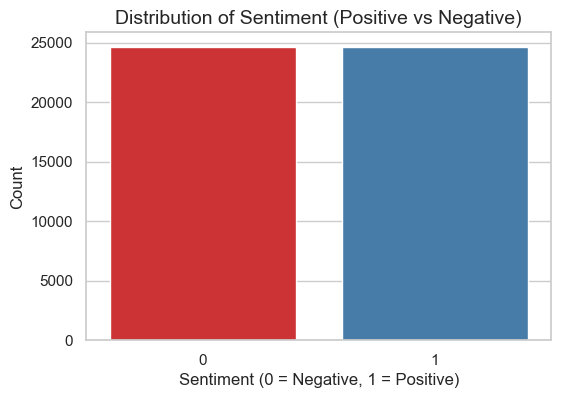

In [11]:

# 1. Sentiment Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=sampled_df, palette="Set1")
plt.title('Distribution of Sentiment (Positive vs Negative)', fontsize=14)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()

As the dataset has been selected and prepared, we have a perfect balance between the two classes.

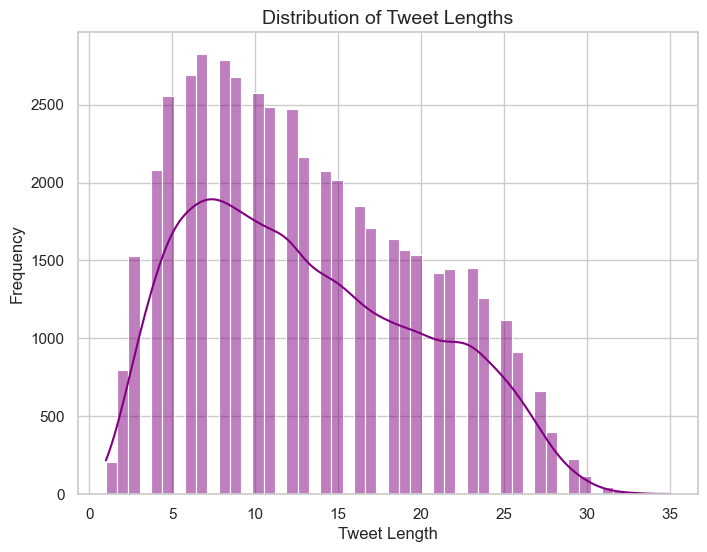

In [12]:
# 2. Tweet Length Analysis 
sampled_df['text_length'] = sampled_df['text'].apply(lambda x: len(str(x).split()))
# Visualizing Tweet Length Distribution
plt.figure(figsize=(8, 6))
sns.histplot(sampled_df['text_length'], bins=50, kde=True, color="purple")
plt.title('Distribution of Tweet Lengths', fontsize=14)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

The shape of the chart suggest shorter Tweets are more commong than long ones. The Tweets lenght follow a normal distribution, with most of them having a length around the average, and fewer of them being very short or very long.

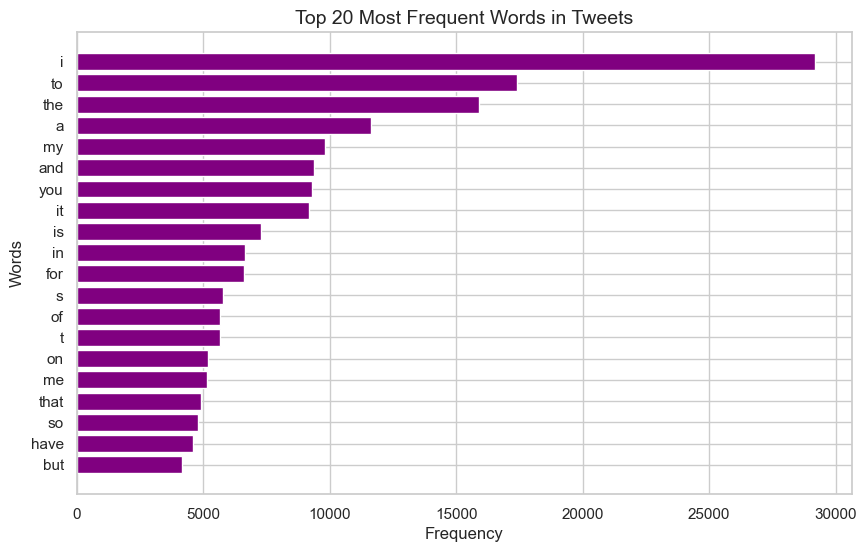

In [ ]:
# 3. Word Frequency Plot
# Function to clean and tokenize text
def clean_text(text):
    # Remove non-alphabetic characters and split into words
    words = re.findall(r'\b\w+\b', str(text).lower())
    return words
# Combine all Tweets into a single string and clean them
all_words = []
for tweet in sampled_df['text']:
    all_words.extend(clean_text(tweet))

# Count word frequencies
word_counts = Counter(all_words)
# Get the 20 most common words
common_words = word_counts.most_common(20)
# Unzip the list of common words and their counts
words, counts = zip(*common_words)

# Plot the 20 most common words
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color="purple")
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words in Tweets', fontsize=14)
plt.gca().invert_yaxis() # Invert y-axis to have the most frequent word at the top
plt.show()

The above chart is not really helpful as all of the words are prepositons, pronouns, isolated letters, etc. So we do not extract much information from this chart. This type of stopwords will be handled later in the notebook.

In the following plots we will explore the relationship between the sentiment and the date information that we have to check if we can find any interesting pattern.

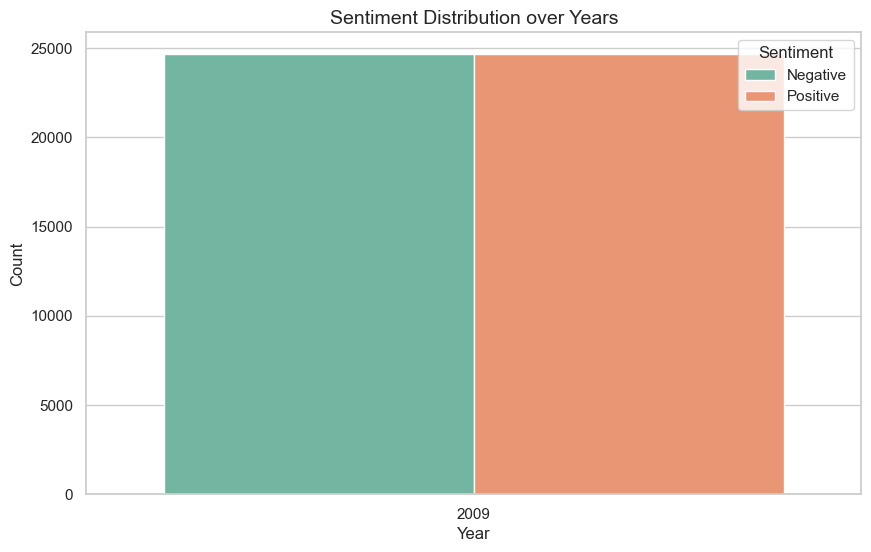

In [14]:
# 4. Sentiment vs. Year Analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='year', hue='sentiment', data=sampled_df, palette="Set2")
plt.title('Sentiment Distribution over Years', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.show()

We do not extract much information from this plot as we only have data from one year (2009).

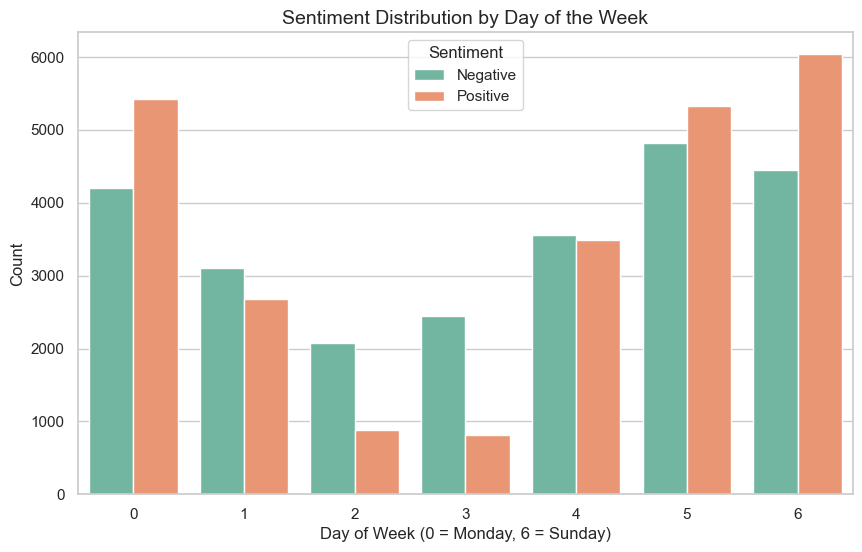

In [15]:
# 5. Sentiment vs. Day of the Week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', hue='sentiment', data=sampled_df, palette="Set2")
plt.title('Sentiment Distribution by Day of the Week', fontsize=14)
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Count')
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.show()

We can see some interesting patterns here, first we can see that most of the Tweets from the dataset selection were posted at the beginning of the week, on Monday and at the end of the week, specially during the weekend and more importantly, we can see that the positive Tweets tend to appear on Monday, Saturday and Sunday; while the negative ones tend to appear during week days, between Tuesday and Friday.

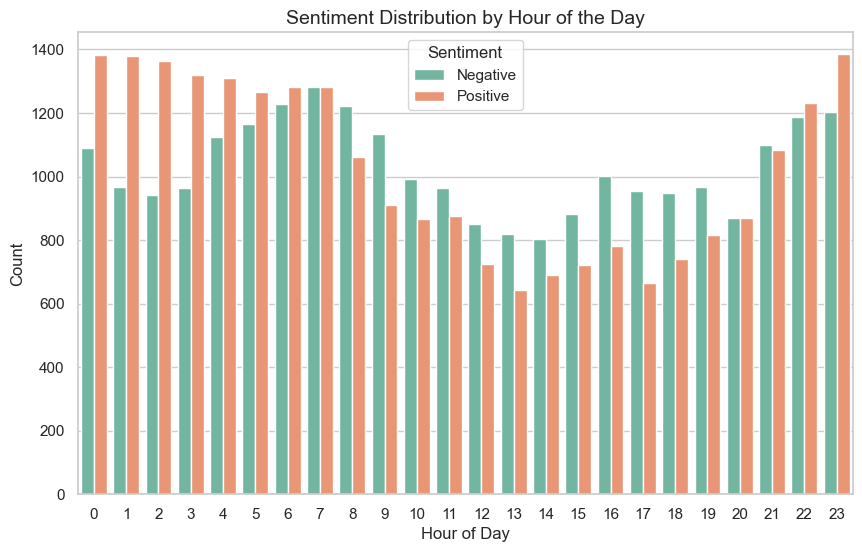

In [16]:
# 6. Sentiment vs. Hour of the Day
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', hue='sentiment', data=sampled_df, palette="Set2")
plt.title('Sentiment Distribution by Hour of the Day', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.show()

In this plot, we can also see another interesting tren. When it comes to the hours of the day, the Tweets are mostly located between midnight and early morning and during the night, that means that most of the Tweets were posted outside typical working/ school hours.

Focusing on the sentiment of the Tweet, we can see that the positive ones were posted mainly during the night, from 0 to 7 and between 22 and 23; while the negative ones are gathered during working hours, between 8 and late afternoon, 21.

## **Step 3: Feature Engineering**

In this step I will prepare the textual data for the ML models. These are the steps that I will implement:

1-Text Cleaning: Convert text to lowercase, remove punctuation, special characters, and stopwords.

2-Tokenization: Split text into individual words (tokens).

3-Removing Stopwords: Eliminate common words that do not contribute to sentiment (e.g., "the", "is", "and").

4-Stemming/Lemmatization: Reduce words to their base form (e.g., "running" → "run").

5-TF-IDF Vectorization: Convert the cleaned and tokenized text into numerical features using TF-IDF to capture the importance of words in the context of the dataset.


In [ ]:
# Ensure necessary NLTK resources are downloaded
try:
    nltk.download("stopwords")
    nltk.download("punkt")
    nltk.download("wordnet")
    nltk.download("averaged_perceptron_tagger")
except:
    print("NLTK download failed.")

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to get POS tags for better lemmatization
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # Default to noun if unknown

# Updated text preprocessing function
def preprocess_text(text, use_stemming=False, use_lemmatization=True):
    # Remove non-alphabetic characters and convert to lowercase
    words = re.findall(r'\b\w+\b', str(text).lower())
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Apply stemming or lemmatization
    if use_stemming:
        words = [stemmer.stem(word) for word in words]
    elif use_lemmatization:
        words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return " ".join(words)

# Apply preprocessing to the dataset
sampled_df["clean_text"] = sampled_df["text"].apply(lambda x: preprocess_text(x, use_stemming=False, use_lemmatization=True))
# Display some samples
print(sampled_df[["text", "clean_text"]].head())

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(sampled_df["clean_text"])
print("TF-IDF Feature Matrix Shape:", X_tfidf.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelaft/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/angelaft/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/angelaft/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/angelaft/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


                                                text  \
0                 well its just like spanish really    
1  Eff up number one fallin asleep in the car  so...   
2  I am so so so so so bored of studying  REALLY....   
3  @g3mini521 its too soon...ill wait awhile. if ...   
4                          @mrw00dy comment for you    

                                          clean_text  
0                           well like spanish really  
1              eff number one fallin asleep car cool  
2            bore study really anyone get idea study  
3  g3mini521 soon ill wait awhile play ill sad cause  
4                                    mrw00dy comment  
TF-IDF Feature Matrix Shape: (49304, 5000)


In [18]:
# Feature: Number of hashtags
sampled_df["num_hashtags"] = sampled_df["text"].apply(lambda x: x.count("#"))
# Feature: Number of mentions
sampled_df["num_mentions"] = sampled_df["text"].apply(lambda x: x.count("@"))
# Feature: Number of links
sampled_df["num_links"] = sampled_df["text"].apply(lambda x: len(re.findall(r"http\S+", x)))
# Combine these new features into the dataset
feature_columns = ["text_length", "num_hashtags", "num_mentions", "num_links"]
X_additional = sampled_df[feature_columns]
# Concatenate additional features with TF-IDF features
X_final = np.hstack((X_tfidf.toarray(), X_additional.to_numpy()))
# Display the shape
print("Final Feature Matrix Shape (TF-IDF + Additional):", X_final.shape)

Final Feature Matrix Shape (TF-IDF + Additional): (49304, 5004)


In [19]:
# Tokenize each tweet into a list of words
sampled_df["tokenized_text"] = sampled_df["clean_text"].apply(lambda x: x.split())
# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=sampled_df["tokenized_text"], vector_size=100, window=5, min_count=2, workers=4)
# Function to get tweet embeddings
def get_tweet_embedding(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else np.zeros(model.vector_size)

# Apply embeddings to each tweet
X_embeddings = np.array([get_tweet_embedding(words, word2vec_model) for words in sampled_df["tokenized_text"]])
# Display shape of embedding matrix
print("Word2Vec Embedding Shape:", X_embeddings.shape)
# Combine additional features (hashtags, mentions, links) with Word2Vec embeddings
X_additional = sampled_df[feature_columns]
# Concatenate Word2Vec embeddings with additional features
X_word2vec_final = np.hstack((X_embeddings, X_additional.to_numpy()))
# Display the shape of the final feature matrix
print("Final Feature Matrix Shape (Word2Vec + Additional):", X_word2vec_final.shape)

# I will use TF-IDF features for our modeling
X = X_final  # Features (TF-IDF + Additional features)
y = sampled_df['sentiment']  # Target labels (sentiment)

Word2Vec Embedding Shape: (49304, 100)
Final Feature Matrix Shape (Word2Vec + Additional): (49304, 104)


## Step 4: **Model Training**

In this step I will train the three ML models Logistic Regression, Random Forest and LightGBM. I will:

1-Split the data into training and testing set. I will use the division 80% train and 20% test.

2-Train the models on the training set and evaluate them.

In [20]:
# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (39443, 5004)
Test set size: (9861, 5004)


In [ ]:
# Function to train, evaluate and display model results
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Training time: {train_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Classification Report:\n{class_report}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    return {
        'model': model,
        'accuracy': accuracy,
        'training_time': train_time
    }

In [ ]:
# Initialize LR model with optimized parameters
lr_model = LogisticRegression(max_iter=150, 
                              solver='saga', 
                              tol=1e-3, n_jobs=4, 
                              verbose=1)


In [ ]:
# Initialize RF model with optimized parameters

rf_model = RandomForestClassifier(n_estimators=50,  # Fewer trees
                                 max_depth=10,  # Limit tree depth
                                 min_samples_split=10,
                                 n_jobs=-1,  # Parallel processing
                                 random_state=42,
                                 warm_start=True, 
                                 verbose=10)  # Show progress


In [ ]:
# Initialize LightGBM model with optimized parameters
lgb_model = lgb.LGBMClassifier(n_estimators=50,  # Fewer trees
                              learning_rate=0.1,
                              num_leaves=31,  # Default leaves
                              min_data_in_leaf=20,  # Minimal number of data in one leaf
                              max_bin=255,  # Larger value to avoid under-fitting
                              n_jobs=-1,  # Parallel processing
                              random_state=42,
                              verbosity=1)  # Show progress


After the initialization, we will train and evaluate the base models.

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.40371746
Epoch 3, change: 0.24455669
Epoch 4, change: 0.17542995
Epoch 5, change: 0.13678442
Epoch 6, change: 0.11142999
Epoch 7, change: 0.094693195
Epoch 8, change: 0.080477485
Epoch 9, change: 0.070285402
Epoch 10, change: 0.061856334
Epoch 11, change: 0.055337553
Epoch 12, change: 0.049559646
Epoch 13, change: 0.044438099
Epoch 14, change: 0.040519522
Epoch 15, change: 0.037711852
Epoch 16, change: 0.03508781
Epoch 17, change: 0.033168947
Epoch 18, change: 0.031091858
Epoch 19, change: 0.029327041
Epoch 20, change: 0.027773946
Epoch 21, change: 0.026281624
Epoch 22, change: 0.025039306
Epoch 23, change: 0.023909611
Epoch 24, change: 0.022751199
Epoch 25, change: 0.021778982
Epoch 26, change: 0.020860724
Epoch 27, change: 0.019970186
Epoch 28, change: 0.019192212
Epoch 29, change: 0.01845231
Epoch 30, change: 0.017732076
Epoch 31, change: 0.017049958
Epoch 32, change: 0.01646591
Epoch 33, change: 0.01591481
Epoch 34, change: 0.015383432
Epoch 35

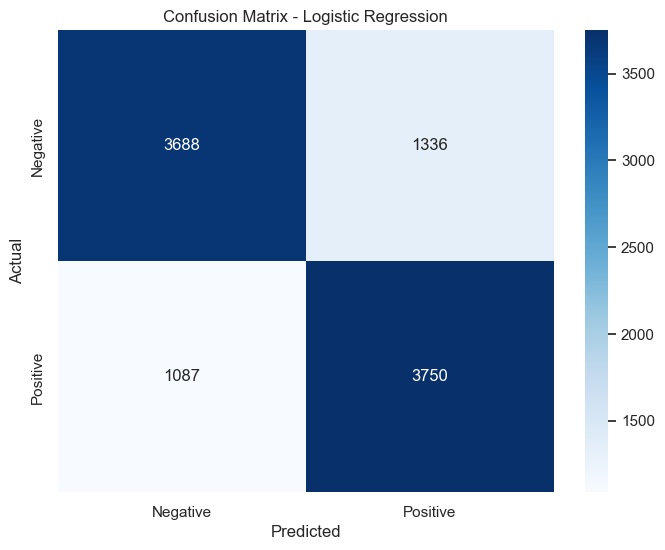

In [ ]:
# Train and evaluate base models
results = []
results.append(evaluate_model(lr_model, "Logistic Regression", X_train, X_test, y_train, y_test))

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Number of positive: 19815, number of negative: 19628
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 63433
[LightGBM] [Info] Number of data points in the train set: 39443, number of used features: 1740
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502371 -> initscore=0.009482
[LightGBM] [Info] Start training from score 0.009482
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20

LightGBM Results:
Training time: 1.91 seconds
Accuracy: 0.7271
Classificat

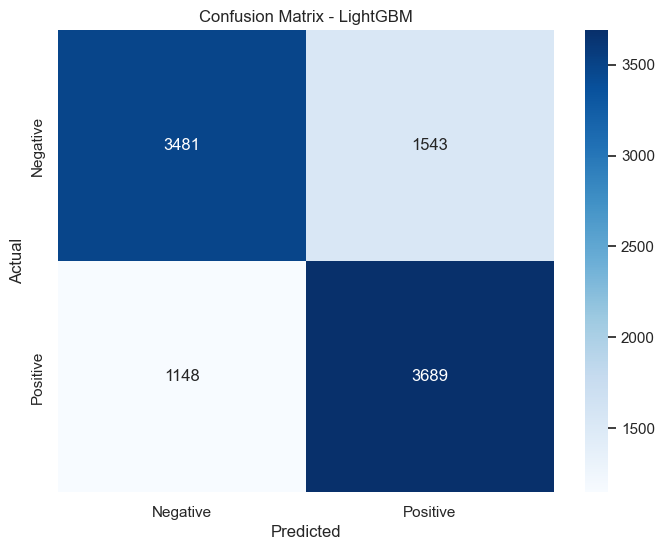

In [26]:
results.append(evaluate_model(lgb_model, "LightGBM", X_train, X_test, y_train, y_test))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s


building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.1s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s


building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s


building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50


[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    2.7s remaining:    0.6s


building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:    3.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  41 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  47 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished



Random Forest Results:
Training time: 3.74 seconds
Accuracy: 0.6976
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.58      0.66      5024
           1       0.65      0.82      0.73      4837

    accuracy                           0.70      9861
   macro avg       0.71      0.70      0.69      9861
weighted avg       0.71      0.70      0.69      9861

Confusion Matrix:
[[2925 2099]
 [ 883 3954]]


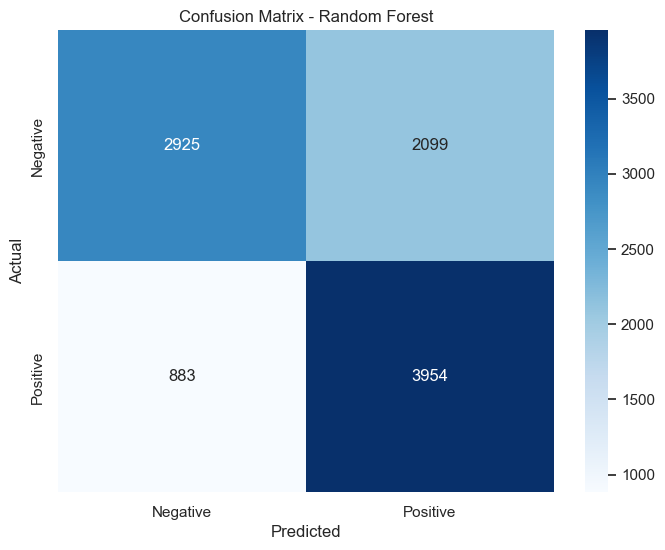

In [27]:
results.append(evaluate_model(rf_model, "Random Forest", X_train, X_test, y_train, y_test))


**Base models' results**

1- Logistic Regression:

-Achieved the highest accuracy (0.7543) among the three models.

-Shows a balanced performance with similar precision, recall, and f1-score for both classes.

-The confusion matrix indicates that the model misclassifies a moderate number of samples but maintains a balance between false positives and false negatives.

-However, it has the longest training time (146.35 seconds), which might be a concern for large datasets.


2-LightGBM:

-Has the fastest training time (1.91 seconds), making it the most efficient model computationally.

-Accuracy (0.7271) is slightly lower than Logistic Regression but still reasonable.

-Shows a good balance between precision and recall but tends to misclassify more samples compared to Logistic Regression.

-The confusion matrix suggests it struggles slightly more with classifying the majority class correctly compared to Logistic Regression.


3-Random Forest:

-Has the lowest accuracy (0.6976), indicating it underperforms relative to the other models.

-Precision for class 0 (0.77) is higher, but recall is significantly lower (0.58), suggesting that it is conservative in predicting class 0.

-Recall for class 1 is the highest (0.82), meaning it is good at identifying positive cases but at the cost of misclassifying many class 0 instances.

-The training time (3.74 seconds) is reasonable but higher than LightGBM.


Conclusions:


-If accuracy is the priority, Logistic Regression is the best choice despite its long training time.

-If speed is the priority, LightGBM is the best as it trains significantly faster with a small accuracy drop.

-If recall for class 1 is critical, Random Forest might be useful, but its lower accuracy and poor precision for class 1 could be problematic.


## **Step 5: Hyperparameter tuning**

In this step I will tune the hyperparameters of the 3 models to improve their performance. I will try to improve the models' performance while trying to keep reasonable training times and computational needs using HalvingGridSearchCV.

In [ ]:
# Logistic Regression Hyperparameter tuning
# Smaller subset for initial hyperparameter tuning
X_sample, X_tune, y_sample, y_tune = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Using {X_sample.shape[0]} samples for initial tuning")

# Logistic Regression - simplified grid
print("\nTuning Logistic Regression...")
lr_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],  # Reduced to just l2 which is often sufficient
    'solver': ['saga']  # Saga works well for l1 and l2, and is generally faster
}
lr_grid = HalvingGridSearchCV(LogisticRegression(random_state=42, max_iter=500), 
                              lr_param_grid, factor=2, cv=3, n_jobs=-1, verbose=1)
lr_grid.fit(X_sample, y_sample)
print(f"Best Logistic Regression parameters: {lr_grid.best_params_}")
lr_tuned = lr_grid.best_estimator_


Using 31554 samples for initial tuning

Tuning Logistic Regression...
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 15777
max_resources_: 31554
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 3
n_resources: 15777
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

----------
iter: 1
n_candidates: 2
n_resources: 31554
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The ma

Best Logistic Regression parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
# Random Forest Hyperparameter tuning
# Use a smaller subset of data for initial hyperparameter tuning
X_sample, X_tune, y_sample, y_tune = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
print(f"Using {X_sample.shape[0]} samples for initial tuning")

# Define the hyperparameter grid
rf_param_dist = {
    'n_estimators': [150, 250, 500],  
    'max_depth': [10, 20, 30],  
    'min_samples_split': [15, 20],
    'min_samples_leaf': [5,10],  # Include more values for minimum samples per leaf
    'max_features': ['sqrt', 'log2']  
}

# Halving Random Search CV
rf_halving = HalvingRandomSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),  # Ensure parallelism
    rf_param_dist,
    factor=3,  # Aggressive elimination
    cv=5,  # Increase cross-validation folds for more robust evaluation
    n_jobs=-1,  # Parallel execution
    verbose=1
)

print("\nTuning Random Forest...")
rf_halving.fit(X_sample, y_sample)

# Best model
print(f"Best Random Forest parameters: {rf_halving.best_params_}")
rf_tuned = rf_halving.best_estimator_


Using 19721 samples for initial tuning

Tuning Random Forest...
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 10
min_resources_: 20
max_resources_: 19721
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 20
Fitting 5 folds for each of 72 candidates, totalling 360 fits
----------
iter: 1
n_candidates: 36
n_resources: 40
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 18
n_resources: 80
Fitting 5 folds for each of 18 candidates, totalling 90 fits
----------
iter: 3
n_candidates: 9
n_resources: 160
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 4
n_candidates: 5
n_resources: 320
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 5
n_candidates: 3
n_resources: 640
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 6
n_candidates: 2
n_resources: 1280
Fitting 5 folds for each of 2 candidates, totalling 10 fit

In [64]:
# Ensure X_sample is a DataFrame to avoid feature name issues
if not isinstance(X_sample, pd.DataFrame):
    X_sample = pd.DataFrame(X_sample)

print("\nTuning LightGBM...")

# Create a validation set for early stopping
X_lgb_train, X_lgb_val, y_lgb_train, y_lgb_val = train_test_split(
    X_sample, y_sample, test_size=0.1, random_state=42
)

lgb_param_dist = {
    'num_leaves': [20, 40, 60, 80],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [1000],
    'min_child_samples': [5, 10, 20, 30]
}

# Define the early stopping callback with no verbosity
early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=False)

# HalvingRandomSearchCV with suppressed logging
lgb_halving = HalvingRandomSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=-1),  # Suppress logs
    lgb_param_dist,
    factor=3,
    cv=3,
    n_jobs=-1,
    verbose=0  # Minimize search output
)

# Fit model
lgb_halving.fit(X_lgb_train, y_lgb_train)

# Output best parameters
print(f"Best LightGBM parameters: {lgb_halving.best_params_}")

# Retrain with the best params but add early stopping
best_params = lgb_halving.best_params_.copy()
best_params['n_estimators'] = 1000  # Set high, early stopping will handle it

# Ensure X_train and X_test are DataFrames to avoid feature name warnings
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=X_sample.columns)
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=X_sample.columns)

# Train the final model
lgb_tuned = lgb.LGBMClassifier(random_state=42, **best_params, verbose=-1)
lgb_tuned.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping]
)


Tuning LightGBM...
Best LightGBM parameters: {'num_leaves': 60, 'n_estimators': 1000, 'min_child_samples': 5, 'learning_rate': 0.05}


LGBMClassifier(learning_rate=0.05, min_child_samples=5, n_estimators=1000,
               num_leaves=60, random_state=42, verbose=-1)

In the following cells I will evaluate and compare the tuned models to see if they have improved their performance and which one is the best model.


Tuned Logistic Regression Results:
Training time: 478.74 seconds
Accuracy: 0.7627
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      5024
           1       0.75      0.78      0.76      4837

    accuracy                           0.76      9861
   macro avg       0.76      0.76      0.76      9861
weighted avg       0.76      0.76      0.76      9861

Confusion Matrix:
[[3743 1281]
 [1059 3778]]


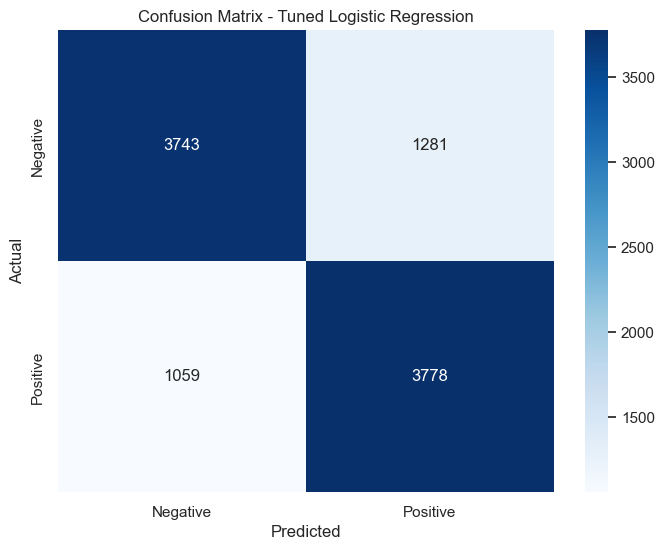


Tuned Random Forest Results:
Training time: 9.71 seconds
Accuracy: 0.7125
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      5024
           1       0.68      0.78      0.73      4837

    accuracy                           0.71      9861
   macro avg       0.72      0.71      0.71      9861
weighted avg       0.72      0.71      0.71      9861

Confusion Matrix:
[[3261 1763]
 [1072 3765]]


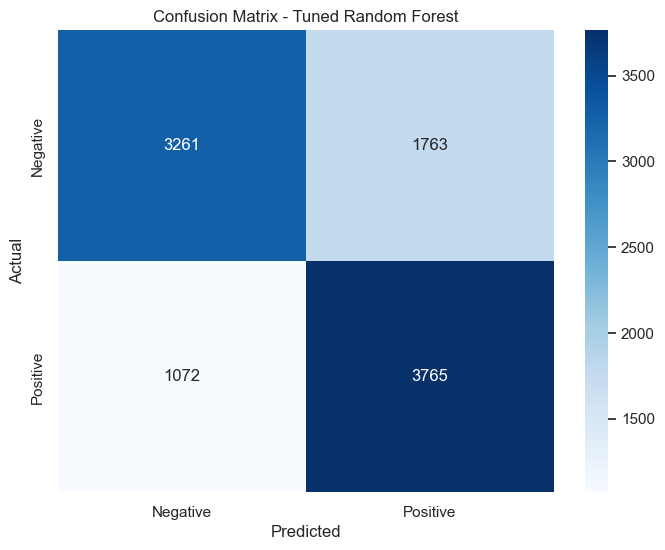


Tuned LightGBM Results:
Inference time: 0.42 seconds
Accuracy: 0.7537
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      5024
           1       0.73      0.79      0.76      4837

    accuracy                           0.75      9861
   macro avg       0.76      0.75      0.75      9861
weighted avg       0.76      0.75      0.75      9861

Confusion Matrix:
[[3604 1420]
 [1009 3828]]


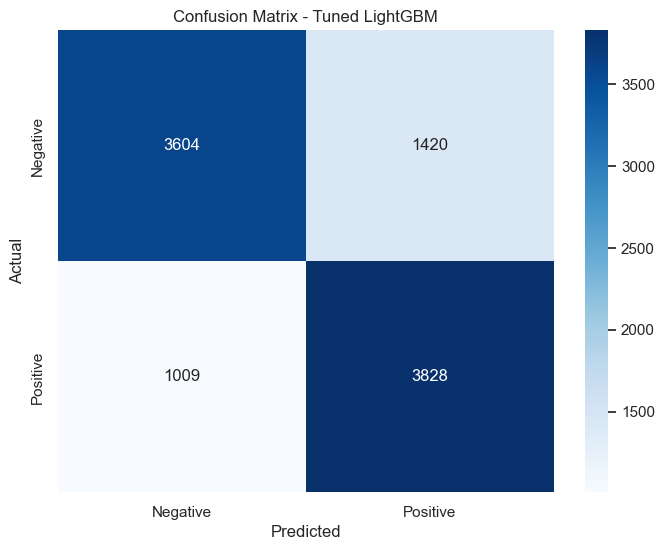

In [65]:
# Evaluate the tuned models
results.append(evaluate_model(lr_tuned, "Tuned Logistic Regression", X_train, X_test, y_train, y_test))
results.append(evaluate_model(rf_tuned, "Tuned Random Forest", X_train, X_test, y_train, y_test))

start_time = time.time()
y_pred = lgb_tuned.predict(X_test)
train_time = time.time() - start_time
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nTuned LightGBM Results:")
print(f"Inference time: {train_time:.2f} seconds")
print(f"Accuracy: {accuracy:.4f}")
print(f"Classification Report:\n{class_report}")
print(f"Confusion Matrix:\n{conf_matrix}")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned LightGBM')
plt.show()
# Add to results
results.append({
    'model': lgb_tuned,
    'accuracy': accuracy,
    'training_time': train_time
})


Model Comparison:
                    Model  Tuned  Accuracy  Training Time
3      LogisticRegression   True  0.760876     493.445362
0      LogisticRegression  False  0.754285     146.350535
5          LGBMClassifier   True  0.750431       0.295369
1          LGBMClassifier  False  0.727107       1.912760
4  RandomForestClassifier   True  0.708954       6.969144
2  RandomForestClassifier  False  0.697597       3.735098


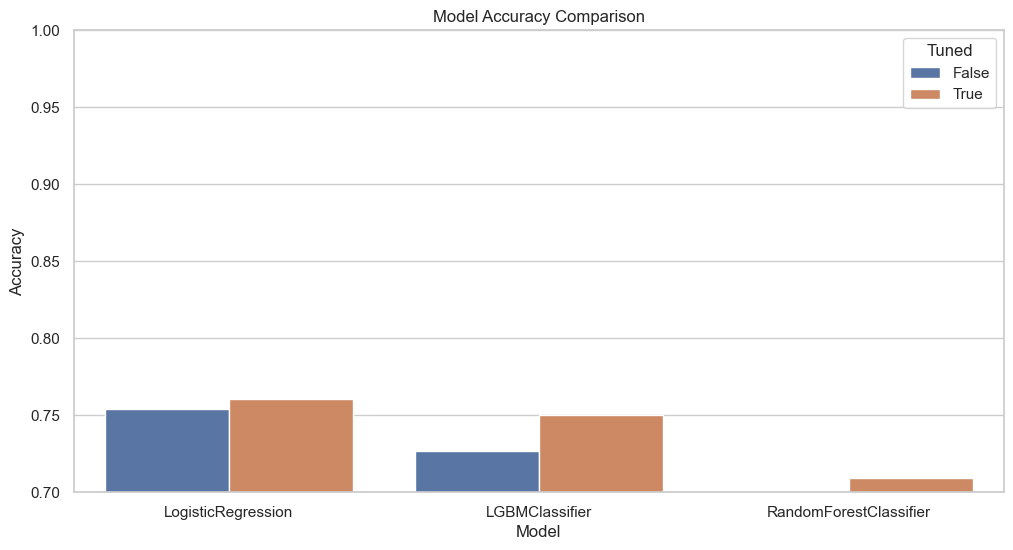

In [67]:
# Compare all models
results_df = pd.DataFrame([
    {'Model': r['model'].__class__.__name__, 
     'Tuned': 'Tuned' in k, 
     'Accuracy': r['accuracy'], 
     'Training Time': r['training_time']}
    for k, r in zip(['LR', 'RF', 'LGB', 'Tuned LR', 'Tuned RF', 'Tuned LGB'], results)
])

# Sort by accuracy
results_df = results_df.sort_values('Accuracy', ascending=False)
print("\nModel Comparison:")
print(results_df)

# Plot model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', hue='Tuned', data=results_df)
plt.title('Model Accuracy Comparison')
plt.ylim(0.7, 1.0)  # Adjust as needed
plt.show()

## **Evaluation Comments**
### 1. **Tuned Logistic Regression:**
- **Accuracy:** The tuned version slightly improved with an accuracy of **0.7627** (up from 0.7543), showing a small but noticeable improvement.
- **Training Time:** The training time significantly increased to **478.74 seconds** (up from 146.35 seconds), indicating that the tuning process added complexity and time.
- **Precision/Recall/F1-Score:**  
  - The precision, recall, and F1-score for both classes improved marginally.  
  - Class 0's recall improved from **0.73 to 0.75**.  
  - Class 1’s recall remained at **0.78**.  
  - This suggests the tuning improved the model’s ability to capture both classes more effectively.
- **Confusion Matrix:**  
  - The tuned model made fewer misclassifications, particularly for class 0.  
  - **3743 correct predictions vs. 3688 in the base model**, which is a sign of improved performance.

### 2. **Tuned Random Forest:**
- **Accuracy:** The tuned Random Forest model improved slightly with an accuracy of **0.7125** (up from 0.6976), but the improvement is modest.
- **Training Time:** The training time increased to **9.71 seconds** (up from 3.74 seconds), but it is still relatively fast compared to Logistic Regression.
- **Precision/Recall/F1-Score:**  
  - There is a slight balance improvement between precision and recall for both classes.  
  - Class 0's precision improved from **0.72 to 0.75**, while recall decreased from **0.70 to 0.65**.  
  - For class 1, precision improved from **0.65 to 0.68**, but recall improved more significantly from **0.72 to 0.78**.  
- **Confusion Matrix:**  
  - While the number of misclassifications decreased slightly, there is still a noticeable issue with false positives for class 0.  
  - **3261 correct predictions vs. 2925 in the base case**.

### 3. **Tuned LightGBM:**
- **Accuracy:** The tuned LightGBM model shows a slight improvement in accuracy, achieving **0.7537** (up from 0.7271). This represents a noticeable performance boost.
- **Inference Time:** The inference time is **0.42 seconds**, which is a significant advantage for deployment and scalability.
- **Precision/Recall/F1-Score:**  
  - There’s a small improvement in precision and recall for both classes.  
  - Class 0's precision increased from **0.75 to 0.76**, and recall improved from **0.69 to 0.72**.  
  - Class 1 showed slight improvements in both precision (**0.71 to 0.73**) and recall (**0.76 to 0.79**).  
- **Confusion Matrix:**  
  - There’s an improvement in correct predictions for both classes, with fewer misclassifications for both class 0 and class 1 compared to the base model.  
  - **3604 correct predictions for class 0 vs. 3481 in the base case**.

In [63]:
# Find the best model based on accuracy
best_model_info = results_df.loc[results_df['Accuracy'].idxmax()]

print(f"\nBest Model: {best_model_info['Model']} ({'Tuned' if best_model_info['Tuned'] else 'Base'})")
print(f"Accuracy: {best_model_info['Accuracy']:.4f}")



Best Model: LogisticRegression (Tuned)
Accuracy: 0.7609


## **Conclusions:**
For this specific business problem—understanding trends and public opinions on various topics based on social media Tweets—our key requirements are **good performance in both classes, quick inference times, and efficiency with large datasets**.

With this in mind, **Tuned Logistic Regression and Tuned LightGBM** are the best options, with the latter offering the added benefit of speed.

- If we prioritize **speed over accuracy**, **Tuned LightGBM** is the most optimal choice, as it offers **high accuracy with minimal training and inference time**.
- **Tuned Random Forest** shows less significant improvements compared to the others, making it a less favorable option for our specific business problem.

Ultimately, **Tuned LightGBM** would be the best option because it combines **strong performance (accuracy of 0.7537) with fast inference time (0.42 seconds)**. This would be particularly useful when analyzing trends across vast amounts of real-time data (e.g., social media posts).

**Tuned Logistic Regression** would also perform well in terms of accuracy, but its **long training time** makes it **less ideal for dynamic and real-time trend analysis**.

In [55]:
import joblib

models_dir = os.path.join("..", "models")
os.makedirs(models_dir, exist_ok=True)

# Save Logistic Regression tuned model
lr_model_path = os.path.join(models_dir, "lr_tuned_sentiment_model.pkl")
joblib.dump(lr_tuned, lr_model_path)
print(f"Tuned Logistic Regression model saved as '{lr_model_path}'")

# Save LightGBM tuned model
lgb_model_path = os.path.join(models_dir, "lgb_tuned_sentiment_model.pkl")
joblib.dump(lgb_tuned, lgb_model_path)
print(f"Tuned LightGBM model saved as '{lgb_model_path}'")

Tuned Logistic Regression model saved as '../models/lr_tuned_sentiment_model.pkl'
Tuned LightGBM model saved as '../models/lgb_tuned_sentiment_model.pkl'



### **Future Considerations:**
Social media posts have a great degree of subjectivity and interpretation. These are made of human language, and these ML models might not be the best option when it comes to getting the subtle nuances of human language (irony, metaphors, etc.). 

One option for further research would be to use a **Large Language Model (LLM)** to classify them, as **LLMs generally perform better in NLP tasks**.